In [1]:
import numpy as np                                                    # Packages for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle
from scipy.ndimage import gaussian_filter1d
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import ipywidgets as ipw
from IPython.display import HTML, display, Javascript, clear_output
from scipy.sparse import csr_matrix
import scipy.io
from scipy.sparse import coo_matrix
import numpy as np
from decimal import Decimal, getcontext

In [2]:
data = scipy.io.loadmat('Figure_4.mat')
fig_4_spikes = data['spks']
example_data = np.array(fig_4_spikes)

In [3]:
example_data[:,0]

array([ 15.,  15.,  15., ..., 541., 541., 541.])

In [4]:
def createFCM(spksExc, spksInh=None):    
    
    # time constant of exponential profile (used for coupling)
    tau = 3e-3

    # 1e-4 binless window step in seconds
    step = 1e-4
    
    # store ids of neurons that really fired -- corresponding to entries in
    # adjacency relation
    
    if spksInh is None:
        old_ids = np.unique(spksExc[:, 0])
        spks = np.column_stack((spksExc, np.ones(len(spksExc))))
    else:
        old_ids = np.unique(np.concatenate((spksExc[:, 0], spksInh[:, 0])))
        spks = np.row_stack((np.column_stack((spksExc, np.ones(len(spksExc)))), 
                             np.column_stack((spksInh, -np.ones(len(spksInh))))))
        
    Eneuron_end = np.max(spksExc[:, 0])
    num_neurons = len(old_ids)
    
    row_indices = old_ids - 1  # Since Python uses 0-based indexing, we subtract 1 from old_ids
    col_indices = np.zeros_like(row_indices)
    values = np.arange(1, num_neurons + 1)

    new_ids = coo_matrix((values, (row_indices, col_indices)), shape=(num_neurons, 1))
    
    # frequency of spiking for individual neurons
    spike_freq = np.zeros(num_neurons)
    
    # duration of spike trains
    t_min = 0
    t_max = np.max(spksExc[:,1])
    T = t_max - t_min
    sig_length = np.ceil(T/step).astype(int)
    
    # Convert the new_ids sparse matrix to a dense NumPy array
    new_ids_array = new_ids.toarray().flatten()

    print(Eneuron_end)

    # Get spiking frequencies
    spike_freq = np.zeros(num_neurons)

    for i in range(1, num_neurons + 1):
        if i <= Eneuron_end:
            neuron_spikes = spksExc[spksExc[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
        else:
            if spksInh is None:
                print("spksInh is None. Make sure it is properly defined.")
                return None
                
            neuron_spikes = spksInh[spksInh[:, 0] == old_ids[i - 1], 1]
            spike_freq[i - 1] = np.sum(neuron_spikes) / T
            
    # create signals for each neuron        
    signals = np.zeros((num_neurons, sig_length))
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        IorE = np.unique(spks[spks[:, 0] == k, 2])
        # how neuron i will influence other neurons
        signals[i - 1, :] = create_signal(spks[spks[:, 0] == k, 1], step, sig_length, tau, IorE)
    
    FC_MAT = np.zeros((num_neurons, num_neurons))
    spike_vecs = np.zeros((num_neurons, sig_length))

    # Previous code up to combining with discrete spiking events...

    # Combine with discrete spiking events
    for i in range(1, num_neurons + 1):
        k = old_ids[i - 1]
        spike_times = spks[spks[:, 0] == k, 1]
        spike_times_vec = coo_matrix((np.ones_like(spike_times), 
                                      (np.ceil(spike_times / step).astype(int) - 1, 
                                       np.zeros_like(spike_times))), 
                                     shape=(sig_length, 1)).toarray().flatten()
        spike_vecs[i - 1, :] = spike_times_vec
        # Influence on neuron i from all other neurons.
        FC_MAT[:, i - 1] = signals.dot(spike_times_vec)

    # Thresholding
    FC_MAT[FC_MAT < 0] = 0
    FC_MAT = FC_MAT - np.diag(np.diag(FC_MAT))

    # Frequency normalization
    freq_normalization = spike_freq / np.maximum(spike_freq, 1)  # Divide element-wise with maximum value of 1
    freq_normalization[freq_normalization > 1] = 1

    FC_MAT = FC_MAT * freq_normalization

    return FC_MAT

In [5]:
def create_signal(start_times, dt, sig_length, tau, mode):
    # time vector
    t_vec = np.arange(dt, (sig_length + 1) * dt, dt)

    q = np.zeros_like(t_vec)

    if mode == 1:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq
    else:
        for k in range(len(start_times)):
            qq = np.exp(-(t_vec - start_times[k]) / tau)
            qq[qq > 1] = 0
            qq = 1 - qq
            qq[qq > 0.99] = 0  # corresponds to ~4.5 tau
            if k < len(start_times) - 1:
                qq[t_vec >= start_times[k + 1]] = 0
            q = q + qq

    # due to rounding of spiking times, the exponential may sometimes not start at 1
    if mode == 1:
        idx = np.ceil(start_times / dt).astype(int) - 1
        idx = np.clip(idx, 0, len(q) - 1)  # Clip indices to be within valid range
        q[idx] = 1

    # shift to zero mean and make magnitude normalized
    q = q - np.mean(q)
    q = q / (np.max(q) * len(start_times))

    return q

In [6]:
FC_MAT = createFCM(example_data)

800.0


/tmp/ipykernel_1034973/3072996499.py:9: RuntimeWarning: overflow encountered in exp
  qq = np.exp(-(t_vec - start_times[k]) / tau)


In [7]:
FC_MAT

array([[0.        , 0.        , 0.        , ..., 0.03317059, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06261507,
        0.        ],
       [0.02339156, 0.        , 0.        , ..., 0.06557252, 0.00057637,
        0.0254416 ],
       ...,
       [0.        , 0.        , 0.07593423, ..., 0.        , 0.        ,
        0.09106372],
       [0.        , 0.07160042, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01065053, 0.1104214 , ..., 0.0826999 , 0.        ,
        0.        ]])

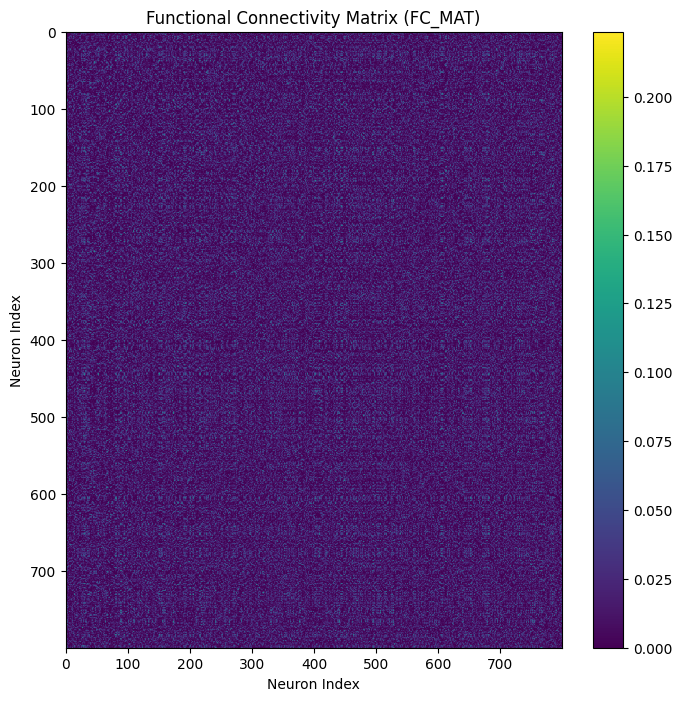

In [8]:
# Plot the heatmap
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.imshow(FC_MAT, cmap='viridis', aspect='auto')
plt.colorbar()  # Add a colorbar for better interpretation
plt.title('Functional Connectivity Matrix (FC_MAT)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

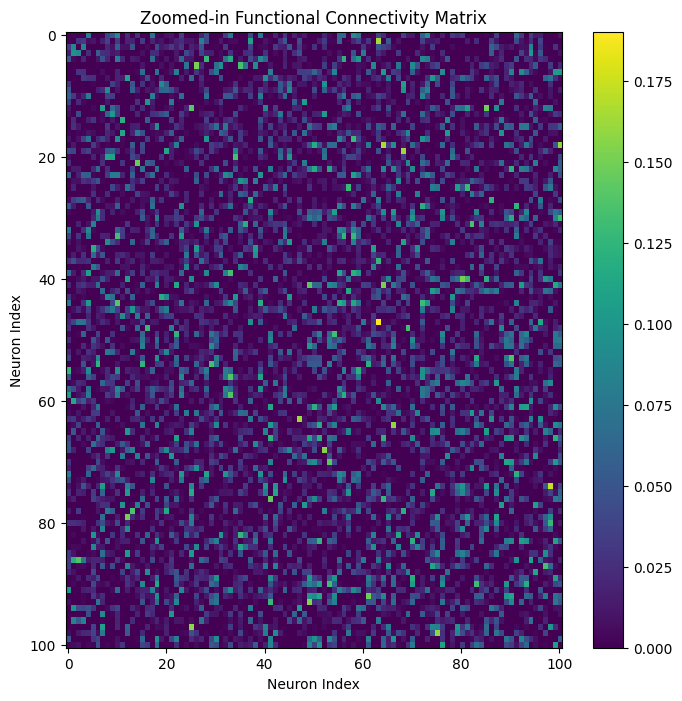

In [9]:
start_index = 100
end_index = 200
roi_FC_MAT = FC_MAT[start_index:end_index+1, start_index:end_index+1]

# Plot the zoomed-in heatmap
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.imshow(roi_FC_MAT, cmap='viridis', aspect='auto')
plt.colorbar()  # Add a colorbar for better interpretation
plt.title('Zoomed-in Functional Connectivity Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

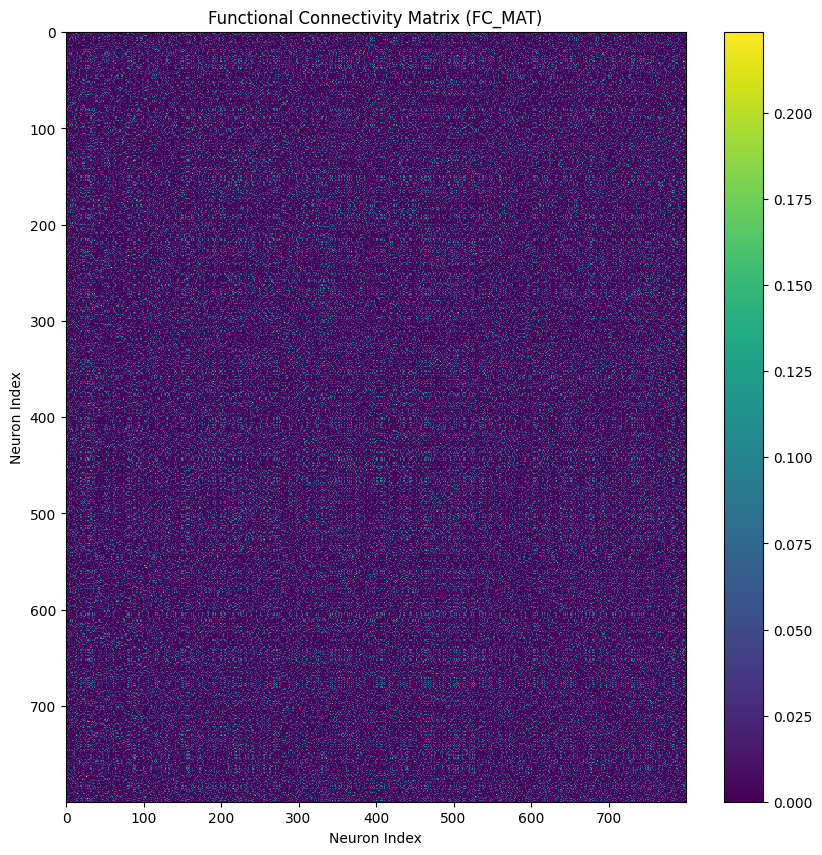

In [10]:
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(FC_MAT, cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar()  # Add a colorbar for better interpretation
plt.title('Functional Connectivity Matrix (FC_MAT)')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()